In [1]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib 
import time

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
def normalise(array):
    # ((X - X_min)/(X_max - X_min) * 2) - 1
    min_value = array.min()
    max_value = array.max()
    
    normalised_array = ((array - min_value)/(max_value - min_value) * 2) - 1
    
    return normalised_array

def make_n_dimensional_ndarray(features):
    return np.array(features).transpose()

def normalise_all_columns(ndarray):
    cols = ndarray.shape[1]
    columns = []
    for i in range(cols):
        unnormalised = np.array([element[i] for element in ndarray])
        normalised = normalise(unnormalised)
        columns.append(normalised)
    return np.array(columns).transpose()

def norm_price(price):
    return (price / (max_price/2)) - 1

def unnorm_price(price):
    return (price + 1)*(max_price/2)

In [3]:
# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    
    x_range = x_max - x_min
    y_range = y_max - y_min
    
    padding_ratio = 0.1
    
    x_pad = x_range * padding_ratio
    y_pad = y_range * padding_ratio
    
    x_h = x_range / 1000
    y_h = y_range / 1000
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(
        np.arange(x_min - x_pad, x_max + x_pad, x_h),
        np.arange(y_min - y_pad, y_max + y_pad, y_h)
    )
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.figure(figsize=(20,20))
#     plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.contour(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

In [4]:
def num_within_xpct(errors, pct_threshold):
    num_errors = float( len(errors) ) 
    num_within_xpercent =  len( [x for x in errors if 0 < x < pct_threshold] )
    pct_within_xpercent = ( num_within_xpercent / num_errors ) * 100
    return (pct_within_xpercent, num_within_xpercent)


def take_sample(X, Y, size):
    data_size = X.shape[0]
    indexes = np.random.randint(0, high=data_size-1, size=size)
    return (X[indexes], Y[indexes])


In [5]:
# Import house price data
melbourne_dtypes = {
    'names':   ('price',   'rooms',   'lat',     'lon',     'date'),
    'formats': ('float32', 'float32', 'float32', 'float32', 'string')
}
melbourne_txns = np.genfromtxt('data/Melbourne_housing_noblanks.csv',
                               #price, rooms, lat, lon, saledate, bedrooms, bathrooms, cars, landsize
                             delimiter=',', usecols=(4,2,17,18,7,10,11,12,13), skip_header=1, 
                             dtype=None
                              )
print("Imported data looks like: {}".format(melbourne_txns[1]))

training_data_pct = 0.7
test_data_pct = 0.3
total_data_size = len(melbourne_txns)
training_data_size = int(total_data_size * training_data_pct)
test_data_size = int(total_data_size * test_data_pct)

y_prices = np.array([np.float32(txn[0]) for txn in melbourne_txns])
max_price = np.amax(y_prices)

y_norm_prices = norm_price(y_prices)

rooms_unnormalied = np.array([np.float32(txn[1]) for txn in melbourne_txns])
lat_unnormalised = np.array([np.float32(txn[2]) for txn in melbourne_txns])
lon_unnormalised = np.array([np.float32(txn[3]) for txn in melbourne_txns])
saledate_unnormalised = np.array([
    np.float32(int(time.mktime(time.strptime( txn[4], '%d/%m/%Y' )))) for txn in melbourne_txns
])
beds_unnormalised = np.array([np.float32(txn[5]) for txn in melbourne_txns])
baths_unnormalised = np.array([np.float32(txn[6]) for txn in melbourne_txns])
cars_unnormalised = np.array([np.float32(txn[7]) for txn in melbourne_txns])
landsize_unnormalised = np.array([np.float32(txn[8]) for txn in melbourne_txns])

X = normalise_all_columns(
    make_n_dimensional_ndarray([
        lat_unnormalised,
        lon_unnormalised,
        rooms_unnormalied,
        saledate_unnormalised,
        beds_unnormalised,
        baths_unnormalised,
        cars_unnormalised,
        landsize_unnormalised
    ])
)


# Training data
X_train = X[0:training_data_size]
Y_train = y_norm_prices[0:training_data_size]
Y_train_unnorm = y_prices[0:training_data_size]

# Testing data
X_test = X[training_data_size:total_data_size]
Y_test = y_norm_prices[training_data_size:total_data_size]
Y_test_unnorm = y_prices[training_data_size:total_data_size]

print("X data shapes are: Total: {} Train: {} Test: {}".format(X.shape, X_train.shape, X_test.shape))
print("Y data shapes are: Total: {} Train: {} Test: {}".format(y_norm_prices.shape, Y_train.shape, Y_test.shape))


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  if __name__ == '__main__':


Imported data looks like: (1035000, 2, -37.8079, 144.9934, '4/02/2016', 2, 1, 0, 156)
X data shapes are: Total: (20993, 8) Train: (14695, 8) Test: (6298, 8)
Y data shapes are: Total: (20993,) Train: (14695,) Test: (6298,)


In [6]:
# Imports and config
import tensorflow as tf
import numpy as np

input_layer_size = X_train.shape[1]
hidden_layer_1_size = 100
hidden_layer_2_size = 5
hidden_layer_3_size = 5
hidden_layer_4_size = 10
output_layer_size = 1

dropout_rate = 0.1

In [7]:
# Manually-created NN
training=tf.placeholder(tf.bool)

# Input
input = tf.placeholder(tf.float32)
target = tf.placeholder(tf.float32)
input_size = tf.to_float(tf.shape(input)[0])
# offset_in = tf.Variable(tf.random_normal([input_layer_size], 0, 0.1))
# scale_in = tf.Variable(tf.random_normal([input_layer_size], 0, 0.1))
# input_offset = input*scale_in + offset_in
h0 = input

# Hidden layers
# Hidden layer 1
weights_W1 = tf.Variable( tf.random_normal([input_layer_size, hidden_layer_1_size], 0, 1))
bias_W1 = tf.Variable( tf.random_normal([hidden_layer_1_size], 0, 1))
h1 = tf.nn.bias_add(tf.matmul(h0, weights_W1), bias_W1)
h2 = tf.tanh(h1)
h2 = tf.layers.dropout(h2, rate=dropout_rate, training=training)

# Hidden layer 2
weights_W1b = tf.Variable(tf.random_normal([hidden_layer_1_size, hidden_layer_2_size], 0, 1))
bias_W1b = tf.Variable(tf.random_normal([hidden_layer_2_size], 0, 1))
h3 = tf.nn.bias_add(tf.matmul(h2, weights_W1b), bias_W1b)
h4 = tf.tanh(h3)
h4 = tf.layers.dropout(h4, rate=dropout_rate, training=training)

# Hidden layer 3
weights_W1c = tf.Variable(tf.random_normal([hidden_layer_2_size, hidden_layer_3_size], 0, 1))
bias_W1c = tf.Variable(tf.random_normal([hidden_layer_3_size], 0, 1))
h5 = tf.nn.bias_add(tf.matmul(h4, weights_W1c), bias_W1c)
h6 = tf.tanh(h5)
h6 = tf.layers.dropout(h6, rate=dropout_rate, training=training)

# Hidden layer 4
weights_W1d = tf.Variable(tf.random_normal([hidden_layer_3_size, hidden_layer_4_size], 0, 1))
bias_W1d = tf.Variable(tf.random_normal([hidden_layer_4_size], 0, 1))
h7 = tf.nn.bias_add(tf.matmul(h6, weights_W1d), bias_W1d)
h8 = tf.tanh(h7)
h8 = tf.layers.dropout(h8, rate=dropout_rate, training=training)

# Output
# Map HL to output
weights_out = tf.Variable(tf.random_normal( [hidden_layer_4_size, output_layer_size], 1, 0.5 ))
bias_out = tf.Variable(tf.random_normal( [output_layer_size], 0, 1 ))
yhat = tf.nn.bias_add(tf.matmul(h8, weights_out), bias_out)

# Offset out
offset_out = tf.Variable(tf.random_normal([output_layer_size], 0, 0))
scale_out = tf.Variable(tf.random_normal([output_layer_size], 1, 0))
# yhat_out = yhat*scale_out + offset_out
# yhat_out = (yhat+offset_out)*scale_out
yhat_out = tf.squeeze( yhat )


# Error
basic_error = yhat_out - target
ratio_error = (basic_error / target)
percent_error = ratio_error * 100
# yerror = (basic_error*100) / input_size
yerror = basic_error
# yerror = ratio_error
loss = tf.nn.l2_loss(yerror)
# loss = yerror


# Optimise the weights
update_weights = tf.train.AdamOptimizer().minimize(loss)

In [8]:
# Train NN and predict

training_steps = 200
epochs = 200
train_sample_size = 100
test_sample_size = 100

# Output vars
train_losses = []
test_losses = []
error_test_means = []
error_test_stds = []
error_test_highpcts = []
error_test_lowpcts = []
error_test_percenterror_means = []
error_test_percenterror_stds = []
percenterror_test_within10pcts = []
percenterror_test_within20pcts = []

saver = tf.train.Saver()
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    for j in range(epochs):
        # Sample data   
        X_test_sample, Y_test_sample = take_sample(X_test, Y_test, test_sample_size)
        X_train_sample, Y_train_sample = take_sample(X_train, Y_train, train_sample_size)
        
        
        # Train on sample
        for i in range(training_steps):
            sess.run(update_weights,
                     feed_dict = {input: X_train_sample, target: Y_train_sample, training: True})

            
        # Losses
        loss_train = loss.eval(feed_dict = {input: X_train_sample, target: Y_train_sample, training: False})
        train_losses.append(loss_train)      

        loss_test = loss.eval(feed_dict = {input: X_test_sample, target: Y_test_sample, training: False})
        test_losses.append(loss_test)

        
        # Error
        error_test = basic_error.eval(feed_dict = {input: X_test_sample, target: Y_test_sample, training: False})
        error_test = abs(error_test)
        
        error_test_mean = np.mean(error_test)
        error_test_means.append(error_test_mean)

        error_test_std = np.std(error_test)
        error_test_stds.append(error_test_std)

        error_test_percentiles = np.percentile(error_test, [25, 27])
        error_test_highpcts.append(error_test_percentiles[1])
        error_test_lowpcts.append(error_test_percentiles[0])

        
        # Percent threshold error
        percenterror_test = percent_error.eval(feed_dict = {input: X_test_sample, target: Y_test_sample, training: False})
        percenterror_test = np.ma.masked_invalid( abs(percenterror_test) )
        
        percenterror_test_mean = np.mean( percenterror_test )
        error_test_percenterror_means.append(percenterror_test_mean)
        
        percenterror_test_std = np.std( percenterror_test )
        error_test_percenterror_stds.append(percenterror_test_std)
        
        percenterror_test_within10pct = num_within_xpct(percenterror_test, 10)
        percenterror_test_within10pcts.append(percenterror_test_within10pct)
        
        percenterror_test_within20pct = num_within_xpct(percenterror_test, 20)
        percenterror_test_within20pcts.append(percenterror_test_within20pct)
        
#         save_path = saver.save(sess, "./model.ckpt")
        
    save_path = saver.save(sess, "./model.ckpt")
    print("Model saved in path: %s" % save_path)

Model saved in path: ./model.ckpt


Within 10 percent: (83.0, 83)
Within 20 percent: (99.0, 99)


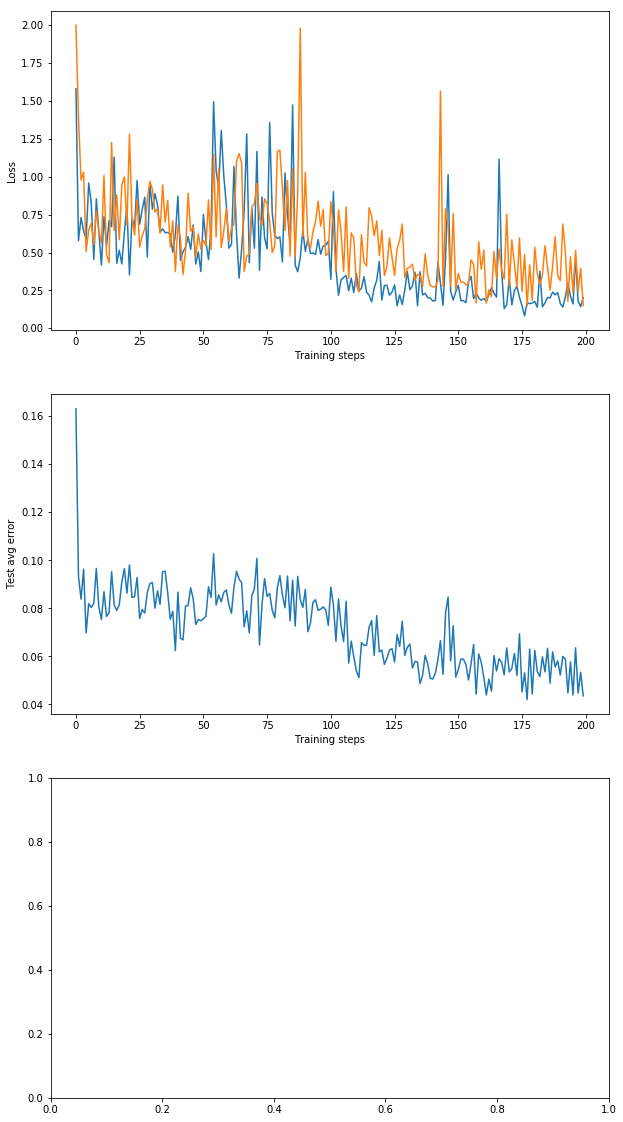

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(10, 20)

# skip=50
skip=0
total_steps = len(train_losses)


# Losses
ax1.plot(range(0, total_steps-skip), train_losses[skip:total_steps])
ax1.plot(range(0, total_steps-skip), test_losses[skip:total_steps])
ax1.set_ylabel("Loss")
ax1.set_xlabel("Training steps")


# Errors
ax2.plot(range(0, total_steps-skip), error_test_means[skip:total_steps])
# ax2.plot(range(0, total_steps-skip), error_test_percenterror_means[skip:total_steps])
# ax2.plot(range(0, total_steps-skip), error_test_percenterror_stds[skip:total_steps])
# ax2.plot(range(0, total_steps-skip), error_test_lowpcts[skip:total_steps])
# ax2.plot(range(0, total_steps-skip), error_test_highpcts[skip:total_steps])
ax2.set_ylabel("Test avg error")
ax2.set_xlabel("Training steps")


# Percent thresholds
# ax3.plot(range(0, total_steps-skip), percenterror_test_within10pcts[skip:total_steps])
# ax3.plot(range(0, total_steps-skip), percenterror_test_within20pcts[skip:total_steps])
# ax3.set_ylabel("% within error margin")
# ax3.set_xlabel("Training steps")


# Stats
final_average = error_test_means[-1]
# final_low_pct = error_test_lowpcts[-1]
# final_high_pct = error_test_highpcts[-1]
final_std = error_test_stds[-1]
# final_avg_pct_error_mean = error_test_percenterror_means[-1]
# final_avg_pct_error_std = error_test_percenterror_stds[-1]
final_avg_10pct = percenterror_test_within10pcts[-1]
final_avg_20pct = percenterror_test_within20pcts[-1]


# Show
# print("Average error: {}, Standard Dev: {}".format(
#    final_average, final_std))
# print("Average pct error: {}, Standard pct Dev: {}".format(
#     final_avg_pct_error_mean, final_avg_pct_error_std))
print("Within 10 percent: {}".format(percenterror_test_within10pct))
print("Within 20 percent: {}".format(percenterror_test_within20pct))
plt.show()

In [10]:
# Output some examples
example_size = 10000

actuals = []
predicteds = []
pct_errors = []

with tf.Session() as sess:
  # Restore variables from disk.
    saver.restore(sess, "./model.ckpt")
    print("Model restored.")
    
    def predict(X_data, Y_data):
        return yhat_out.eval(feed_dict = {input: X_data, target: Y_data, training: False})

    X_examples, Y_examples = take_sample(X_test, Y_test, example_size)
    predictions = predict(X_examples, Y_examples)
    
    for i in range(example_size-1):
        actual = unnorm_price( Y_examples[i] )
        predicted = unnorm_price( predictions[i] )
        pct_error = abs(int( ((float(predicted) - float(actual)) / float(actual) )* 100 ))
        data = X_examples[i]
        
        actuals.append(actual)
        predicteds.append(predicted)
        pct_errors.append(pct_error)
        
#         print('Actual: {}, Predicted: {}, Pct_err: {}, X: {}'.format(actual, predicted, pct_error, data) )
#         print('Actual: {}, Predicted: {}, Pct_err: {}'.format(int(actual), int(predicted), pct_error) )

avg_pct_err = np.mean(pct_errors)
std_pct_err = np.std(pct_errors)
print("Average % error: {}, STDev: {}".format(avg_pct_err, std_pct_err))

within10pct = num_within_xpct(pct_errors, 10)
print("% within 10% accuracy: {}, or {} total".format(within10pct[0], within10pct[1]))
within20pct = num_within_xpct(pct_errors, 20)
print("% within 20% accuracy: {}, or {} total".format(within20pct[0], within20pct[1]))
within50pct = num_within_xpct(pct_errors, 50)
print("% within 50% accuracy: {}, or {} total".format(within50pct[0], within50pct[1]))


INFO:tensorflow:Restoring parameters from ./model.ckpt
Model restored.
Average % error: 25.5165516552, STDev: 24.9654927581
% within 10% accuracy: 25.102510251, or 2510 total
% within 20% accuracy: 47.5847584758, or 4758 total
% within 50% accuracy: 84.4384438444, or 8443 total


Text(0.5,0,'Data')

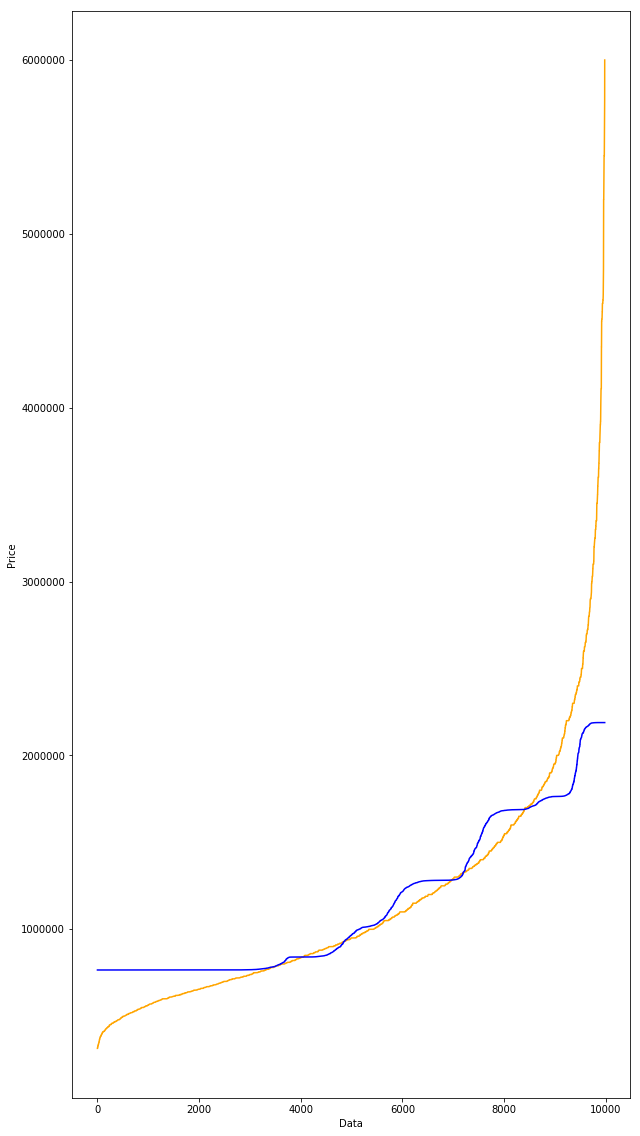

In [11]:
# Plot actuals vs predicteds
fig2, (plt1) = plt.subplots(1)
plt.subplots_adjust(wspace=.3)
fig2.set_size_inches(10, 20)

skip=10
end_skip=10
total_steps = example_size-1

actuals_sorted = np.sort(actuals)
predicteds_sorted = np.sort(predicteds)

# Losses
plt1.plot(range(0, total_steps-skip-end_skip), actuals_sorted[skip:total_steps-end_skip], color='orange')
plt1.plot(range(0, total_steps-skip-end_skip), predicteds_sorted[skip:total_steps-end_skip], color='blue')
plt1.set_ylabel("Price")
plt1.set_xlabel("Data")


In [12]:
# Scores so far:
# Original attempt:
# 10x10x100 network
# 12% within 10% accuracy
# 20% within 20% accuracy

# After fixing the price sampling bug:
# 10x50x100 network
# 21% within 10% accuracy
# 41% within 20% accuracy

# Larger network
# 100x500x1000
# 9% within 10% accuracy
# 20% within 20% accuracy
# Took bloody ages to train

# Smaller network
# 10x10x10
# 27% within 10% accuracy
# 52% within 20% accuracy

# Small hourglass
# 10x5x10
# 27% within 10% accuracy
# 53% within 20% accuracy

# Really small network
# 5x5x5
# 21% within 10% accuracy
# 43% within 20% accuracy

# Minimising ratio error, rather than just yhat - target
# 10x5x20
# 22% within 10% accuracy
# 42% within 20% accuracy

# Wide hourglass, training on basic error
# 50x5x50
# 23% within 10% accuracy
# 44% within 20% accuracy

# Wide hourglass, training on ratio error
# 50x5x50
# 10% within 10% accuracy
# 20% within 20% accuracy

# Funnel
# 50x30x10
# 18% within 10% accuracy
# 39% within 20% accuracy

# Single layer
# 30
# 15% within 10% accuracy
# 31% within 20% accuracy

# 4 layers
# 10x10x10x10
# 24% within 10% accuracy
# 47% within 20% accuracy

# 4 layer hourglass
# 10x5x5x10
# 29% within 10% accuracy
# 56% within 20% accuracy

# Smaller 4 layer hourglass
# 8x4x4x8
# 21% within 10% accuracy
# 43% within 20% accuracy

# Larger 4 layer hourglass
# 100x10x10x100
# 9% within 10% accuracy
# 18% within 20% accuracy


### CURRENT CHAMPION ###
# 4 layer hourglass with 0.1 dropout
# 10x5x5x10
# 30% within 10% accuracy
# 55% within 20% accuracy


# Larger 4 layer hourglass with 0.1 dropout
# 100x10x10x100
# 25% within 10% accuracy
# 48% within 20% accuracy

# Large 4 layer network with 0.1 dropout
# 100x100x100x100
# 23% within 10% accuracy
# 46% within 20% accuracy

# Large 4 layer network with 0.5 dropout
# 100x100x100x100
# 19% within 10% accuracy
# 40% within 20% accuracy

# Large 4 layer network with 0 dropout
# 100x100x100x100
# 14% within 10% accuracy
# 30% within 20% accuracy

# Slightly larger 4 layer hourglass with 0.1 dropout
# 15x7x7x15
# 26% within 10% accuracy
# 49% within 20% accuracy

# 3 layer hourglass with 0.1 dropout
# 10x5x10
# 27% within 10% accuracy
# 50% within 20% accuracy

# Huge 4 layer network, 0.5 dropout
# 1000x1000x1000x1000
# 24% within 10% accuracy
# 50% within 20% accuracy

# Huge 4 layer network, 0.1 dropout
# 1000x1000x1000x1000
# % within 10% accuracy
# % within 20% accuracy


# 
# 
# % within 10% accuracy
# % within 20% accuracy